In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from ptsne.ptsne import ParametricTSNE

# Datasets & Loaders

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
cifar_train = CIFAR10(
    './data',
    train=True,
    download=True,
    transform=transform
)

cifar_test = CIFAR10(
    './data',
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
trainloader = torch.utils.data.DataLoader(cifar_train,
    batch_size=50,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

trainloader_noshuffle = torch.utils.data.DataLoader(cifar_train,
    batch_size=200,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

testloader = torch.utils.data.DataLoader(cifar_test,
    batch_size=200,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# Classifier Network

In [6]:
class Net(nn.Module):
    def __init__(self, use_cuda=True):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 10)
        self.use_cuda = use_cuda
        if self.use_cuda:
            self.cuda()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
def train(log_interval, model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model.forward(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def train_altered(log_interval, model, device, altered_loader, embedding, optimizer, epoch, weight):
    model.train()
    for batch_idx, (data, target, label) in enumerate(altered_loader):
        data, target, label = data.to(device), target.to(device), label.to(device)
        optimizer.zero_grad()
        output = model.forward(data)
        class_loss = torch.nn.CrossEntropyLoss()(output, label)
        embedding_loss = torch.nn.MSELoss()(embedding(output), target) / len(label)
        loss = (1 - weight) * class_loss + weight * embedding_loss
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(altered_loader.dataset),
                100. * batch_idx / len(altered_loader), loss.item()))

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += criterion(output, target).cpu().item()
            pred = output.argmax(dim=1)
            # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Train Initial Network

In [12]:
net = Net()
# net.load_state_dict(torch.load('models/cifar-test-model.pt'))

In [13]:
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [14]:
torch.manual_seed(12)
torch.cuda.manual_seed(12)

torch.backends.cudnn.deterministic=True

In [15]:
for epoch in range(1, 6):
        # log run every epoch

        train(200, net, 'cuda', trainloader, optimizer, criterion, epoch)
        #test(net, 'cuda', testloader, criterion)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.295679
Train Epoch: 1 [10000/50000 (20%)]	Loss: 2.059756
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.661749
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.568382
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.818556
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.548048
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.691106
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.334576
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.066772
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.475412
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.175812
Train Epoch: 3 [10000/50000 (20%)]	Loss: 1.145542
Train Epoch: 3 [20000/50000 (40%)]	Loss: 1.084514
Train Epoch: 3 [30000/50000 (60%)]	Loss: 1.053529
Train Epoch: 3 [40000/50000 (80%)]	Loss: 1.100200
Train Epoch: 4 [0/50000 (0%)]	Loss: 0.871748
Train Epoch: 4 [10000/50000 (20%)]	Loss: 0.989214
Train Epoch: 4 [20000/50000 (40%)]	Loss: 1.079255
Train Epoch: 4 [30000/50000 (60%)]	Loss: 1.255237
Train Epoch: 4 [40000/50000 (80%)]	Loss: 1.012135
Train Epoch: 5 [0/50

In [16]:
torch.save(net.state_dict(), 'models/cifar-before.pt')

# Embedding

In [17]:
net.eval()
with torch.no_grad():
    logits_train = []
    for data, targets in trainloader_noshuffle:
        data = data.cuda()
        logits_train.append(net(data).detach().cpu())
logits_train = torch.cat(logits_train)

with torch.no_grad():
    logits_test = []
    for data, targets in testloader:
        data = data.cuda()
        logits_test.append(net(data).detach().cpu())
logits_test = torch.cat(logits_test)

In [25]:
ptsne = ParametricTSNE(10, 2, 50, use_cuda=True, hidden_layer_dims=[300,100], alpha=1)
# ptsne.load_state_dict(torch.load('models/ptsne-test.pt'))

In [26]:
#ptsne.fit(outputs, pretrain=True,verbose=True)
ptsne.fit(logits_train[::12], pretrain=True, verbose=True)

Calculating PCA
2020-02-27 16:05:54.928567: Beginning pretraining for 5 epochs
2020-02-27 16:05:55.031294: Loss after epoch 0: 54.03848373889923
2020-02-27 16:05:55.221783: Loss after epoch 1: 6.861849009990692
2020-02-27 16:05:55.296583: Loss after epoch 2: 2.6155996322631836
2020-02-27 16:05:55.368391: Loss after epoch 3: 1.23892243206501
2020-02-27 16:05:55.442195: Loss after epoch 4: 0.45268936827778816
2020-02-27 16:05:55.443193: Finished pretraining
Indexing
2020-02-27 16:06:18.263514: Beginning training for 10 epochs
2020-02-27 16:06:18.532794: Loss after epoch 1: 18.09135123072481
2020-02-27 16:06:18.808056: Loss after epoch 2: 17.244648426194924
2020-02-27 16:06:19.116232: Loss after epoch 3: 17.222658684322752
2020-02-27 16:06:19.414436: Loss after epoch 4: 17.256148777665828
2020-02-27 16:06:19.725332: Loss after epoch 5: 16.979404350393185
2020-02-27 16:06:19.996608: Loss after epoch 6: 16.79787961058349
2020-02-27 16:06:20.297802: Loss after epoch 7: 16.808662872528945
202

In [27]:
torch.save(ptsne.state_dict(), 'models/cifar-ptsne.pt')

In [28]:
ptsne.eval()
projected_train = ptsne(logits_train.cuda()).detach().cpu()
projected_test = ptsne(logits_test.cuda()).detach().cpu()

# Determine Suitable Shifts

In [29]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

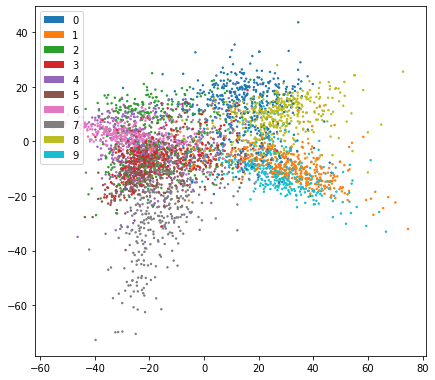

In [30]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in cifar_train.targets[::12]]
ax.scatter(projected_train[::12,0], projected_train[::12,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [36]:
shift = (torch.tensor(cifar_train.targets) == 9).float().unsqueeze(1) * torch.tensor([0.,-10.]) #+ (torch.tensor(cifar_train.targets) == 4).float().unsqueeze(1) * torch.tensor([8.,0.])
shifted_train = projected_train + shift

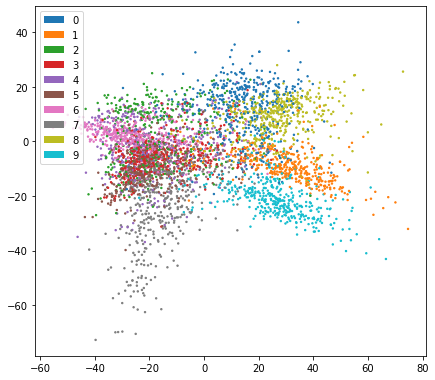

In [37]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in cifar_train.targets[::12]]
ax.scatter(shifted_train[::12,0], shifted_train[::12,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

# Retraining

In [59]:
cifar_train_for_loader = []
for data, target in trainloader_noshuffle:
    cifar_train_for_loader.append(data)
cifar_train_for_loader = torch.cat(cifar_train_for_loader)

In [60]:
shifted_dataset = torch.utils.data.TensorDataset(cifar_train_for_loader, shifted_train, torch.tensor(cifar_train.targets))
shifted_loader = torch.utils.data.DataLoader(shifted_dataset, batch_size=50, shuffle=True)
shifted_loader_noshuffle = torch.utils.data.DataLoader(shifted_dataset, batch_size=50, shuffle=False)

In [133]:
net = Net()
net.load_state_dict(torch.load('models/cifar-before.pt'))

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

for epoch in range(5):
    train_altered(200, net, 'cuda', shifted_loader, ptsne, optimizer, epoch, 0.)

torch.save(net.state_dict(), 'models/cifar-after.pt')

Train Epoch: 0 [0/50000 (0%)]	Loss: 1.011252
Train Epoch: 0 [10000/50000 (20%)]	Loss: 0.960494
Train Epoch: 0 [20000/50000 (40%)]	Loss: 1.012268
Train Epoch: 0 [30000/50000 (60%)]	Loss: 0.891316
Train Epoch: 0 [40000/50000 (80%)]	Loss: 0.938186
Train Epoch: 1 [0/50000 (0%)]	Loss: 0.737764
Train Epoch: 1 [10000/50000 (20%)]	Loss: 0.897130
Train Epoch: 1 [20000/50000 (40%)]	Loss: 0.952293
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.007336
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.202849
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.772742
Train Epoch: 2 [10000/50000 (20%)]	Loss: 0.872077
Train Epoch: 2 [20000/50000 (40%)]	Loss: 0.904284
Train Epoch: 2 [30000/50000 (60%)]	Loss: 0.851342
Train Epoch: 2 [40000/50000 (80%)]	Loss: 0.734469
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.904689
Train Epoch: 3 [10000/50000 (20%)]	Loss: 1.004379
Train Epoch: 3 [20000/50000 (40%)]	Loss: 0.650479
Train Epoch: 3 [30000/50000 (60%)]	Loss: 0.861158
Train Epoch: 3 [40000/50000 (80%)]	Loss: 1.104853
Train Epoch: 4 [0/50

In [134]:
net.eval()
with torch.no_grad():
    new_projected_train = []
    new_logits_train = []
    for data, targets in trainloader_noshuffle:
        out = net(data.cuda())
        new_logits_train.append(out.detach().cpu())
        new_projected_train.append(ptsne(out).detach().cpu())
new_projected_train = torch.cat(new_projected_train)
new_logits_train = torch.cat(new_logits_train)

In [135]:
net.eval()
with torch.no_grad():
    new_projected_test = []
    new_logits_test = []
    for data, targets in testloader:
        out = net(data.cuda())
        new_logits_test.append(out.detach().cpu())
        new_projected_test.append(ptsne(out).detach().cpu())
new_projected_test = torch.cat(new_projected_test)
new_logits_test = torch.cat(new_logits_test)

# Evaluation

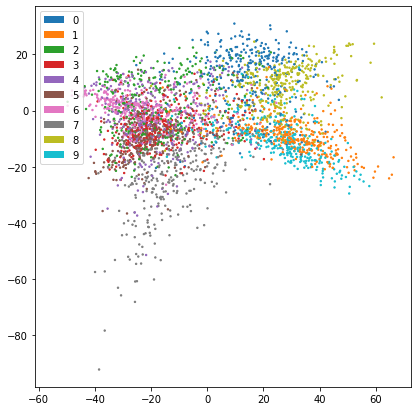

In [124]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in cifar_test.targets[::3]]
ax.scatter(projected_test[::3,0], projected_test[::3,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

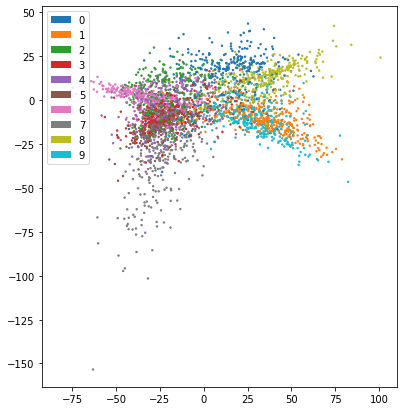

In [136]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in cifar_test.targets[::3]]
ax.scatter(new_projected_test[::3,0], new_projected_test[::3,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [105]:
cf_train = torch.zeros(10,10, dtype=int)
for i in zip(cifar_train.targets, logits_train.argmax(dim=1)):
    cf_train[i] += 1

cf_test = torch.zeros(10,10, dtype=int)
for i in zip(cifar_test.targets, logits_test.argmax(dim=1)):
    cf_test[i] += 1

In [126]:
new_cf_train = torch.zeros(10,10, dtype=int)
for i in zip(cifar_train.targets, new_logits_train.argmax(dim=1)):
    new_cf_train[i] += 1

new_cf_test = torch.zeros(10,10, dtype=int)
for i in zip(cifar_test.targets, new_logits_test.argmax(dim=1)):
    new_cf_test[i] += 1

In [107]:
cf_test.diag().sum().float() / cf_test.sum().float()

tensor(0.6117)

In [127]:
new_cf_test.diag().sum().float() / new_cf_test.sum().float()

tensor(0.6476)

In [111]:
print(cf_test[1,1].float() / cf_test[:,1].sum().float()) # precision 'Auto'
print(cf_test[1,1].float() / cf_test[1,:].sum().float()) # recall

print(cf_test[9,9].float() / cf_test[:,9].sum().float()) # precision 'Truck'
print(cf_test[9,9].float() / cf_test[9,:].sum().float()) # recall

tensor(0.6726)
tensor(0.8320)
tensor(0.6749)
tensor(0.6560)


In [128]:
print(new_cf_test[1,1].float() / new_cf_test[:,1].sum().float()) # precision 'Auto'
print(new_cf_test[1,1].float() / new_cf_test[1,:].sum().float()) # recall

print(new_cf_test[9,9].float() / new_cf_test[:,9].sum().float()) # precision 'Truck'
print(new_cf_test[9,9].float() / new_cf_test[9,:].sum().float()) # recall

tensor(0.7292)
tensor(0.7970)
tensor(0.7475)
tensor(0.6690)


In [132]:
cifar_test.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}